# Exercise Search Algorithms #

We will use data from the swiss railway system (https://data.sbb.ch) to test different search algorithms. You will implement the search algorithms yourself and evaluate their performance.

Let's have a look at the data. The following picture shows the "Betriebsknotenpunkte" of the railway system around Rotkreuz: 


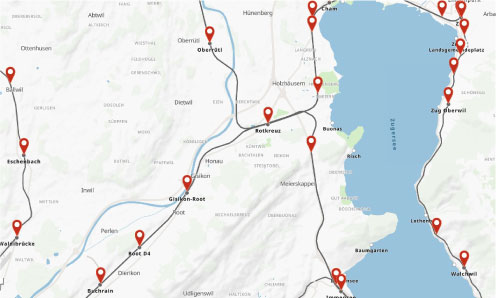

In [1]:
from IPython.display import Image
Image('sbb-map.jpg')

Later on, we will use the data about the "Betriebsknotenpunkte" provided by SBB. But let's start building some usefull classes.

To navigate and to solve problems within the railway system, it is useful to define a graph class, that contains some basic properties and functions. The class is already implemented in the search.py file. Carefully read the code and try to understand its functions.

In [2]:
# %load -s Graph search.py
class Graph:

    """A graph connects nodes (vertices) by edges (links).  Each edge can also
    have a length associated with it.  The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C.  You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added.  You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B.  'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


Additionally, we create a undirected graph class, where every edge goes in both directions. This will be helpful for our SBB network.

In [3]:
# %load -s UndirectedGraph search.py
def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict = graph_dict, directed=False)


Based on this, we can formulate a GraphProblem class, that sets the initial state and the goal state:

In [3]:
# %load -s GraphProblem search.py
class GraphProblem():

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        self.initial = initial
        self.goal = goal
        self.graph = graph

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal
    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or infinity)


The next step is to define the node class. The following scaffold is written in the serach.py file. It's your turn to implement the constructor and the different methods.

In [11]:
# %load -s Node search.py
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        
    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action) for action in problem.actions(self.state)]
    
    def child_node(self, problem, action):
        """Return the child node reached by a given action"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, 
                        problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node
        
    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]
    
    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

To illustrate the use of these classes, we define our text book problem. The `romania_map` is a undirected graph and contains the information about which cities are connected and how long the roads between the cities are:

In [5]:
from search import *
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

You can use the Romania map as follows:

In [6]:
print("get possible children from 'Arad':")
children = romania_map.get('Arad')
print(children);

get possible children from 'Arad':
{'Zerind': 75, 'Sibiu': 140, 'Timisoara': 118}


In [7]:
distance_arad_zerind = romania_map.get('Arad', 'Zerind')
print("get distance between 'Arad' and 'Zerind': " + str(distance_arad_zerind))

get distance between 'Arad' and 'Zerind': 75


We can define our search problem using the undirected graph:

In [8]:
start = 'Arad'
goal = 'Bucharest'
problem = GraphProblem(start, goal, romania_map)

Let's do some tests with the problem class.

In [9]:
# check the goal test
assert not problem.goal_test('Arad')
assert problem.goal_test('Bucharest')

# what actions can we do in Arad?
actions_arad = problem.actions('Arad')
print("actions in Arad: " + ' '.join(actions_arad))

# cost from Arad going to (action=) 'Zerind'
initial_cost = 0
action = 'Zerind'
cost_arad_zerind = problem.path_cost(initial_cost, 'Arad', action,'Zerind')
print("cost from Arad to Zerind: " + str(cost_arad_zerind))

actions in Arad: Zerind Sibiu Timisoara
cost from Arad to Zerind: 75


In [12]:
# create first node of the problem
initial_node = Node(problem.initial)
print('initial node : ' + initial_node.state)

print('children of initial node: ')
children = initial_node.expand(problem)
for child in children:
    print('\t' + child.state)

# lets do action 'Sibiu'
action = 'Sibiu'
next_node = initial_node.child_node(problem, action)
print('action Sibiu leads to: ' + next_node.state)

NotImplementedError: 

In the following exercise sessions, we will implement different search algorithms.